# Smooth myopic data-driven control using `congol`



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import congol as cg

## Parameters for the problem

We let the input to lie in the interval $[-4,4]\times[-\pi,\pi]$.

In [2]:
# Input bounds
v_max = 4
w_max = 0.5 * (2*np.pi)
v_min = -v_max
w_min = -w_max

# Working environment
xlim_tup = [-12, 2]
ylim_tup = [-6, 2]

# Bounds for the contextual optimization problem
input_lb = np.array([v_min, w_min])
input_ub = np.array([v_max, w_max])
context_lb = np.array([xlim_tup[0], ylim_tup[0], -1, -1])
context_ub = np.array([xlim_tup[1], ylim_tup[1], 1, 1])
context_u_lb = np.hstack((context_lb, input_lb))
context_u_ub = np.hstack((context_lb, input_ub))

# Parameters for sequential control
max_oracle_calls = 300                       # Maximum number of time steps
cost_thresh = 1e-1                           # Terminate the sequential control if cost is below this threshold

# Model parameters
sampling_time = 0.1                          # Sampling for the discrete time
n_data_max = 10                              # Number of data points available for precursor training
initial_state = np.array([-2, -2.5, np.pi/2])# Initial data point
time_horizon = n_data_max + max_oracle_calls # Total max. number of time steps
np.random.seed(501) 

# Planning target position
target_position = np.zeros((2,))

# Unicycle dynamics

This function provides the one-step unicycle dynamics. This function is only used for simulation purposes.
Here, the state is $x=[p_x,p_y,\theta]$, position in $\mathrm{xy}$ coordinates and the heading $\theta$. The input is the heading velocity and the turning rate $[v,w]$.

In [3]:
def one_step_dyn(current_state, current_input):
    """
    Expects current_state and current_input as 2D matrices where each row is a
    unique time stamp

    Returns a 2D numpy vector of the same number of rows

    current state has 3 dimensions --- position (x, y) and heading (theta)
    current input has 2 dimensions --- velocity (v) and turning rate (w)
    sampling_time has been defined above
    """
    if current_state.ndim == 2 and current_input.ndim == 2:
        if current_state.shape[0] != current_input.shape[0]:
            raise ValueError('Expected current state and input to have the '
                'same number of rows.')
        x, y, theta = current_state.T
        v, w = current_input.T
        nearly_one = np.ones((current_state.shape[0],))
        nearly_zero = np.zeros((current_state.shape[0],))
    elif current_state.ndim == 1 and current_input.ndim == 1:
        x, y, theta = current_state[:]
        v, w = current_input[:]
        nearly_one = 1
        nearly_zero = 0
    else:
        print(current_state, current_input)
        raise ValueError('state and input must be numpy matrices 1D or 2D')

    delta_v = v * sampling_time
    delta_w = w * sampling_time

    if current_state.ndim == 2:
        # Vector delta_w
        nearly_one[abs(delta_w) > 1e-3] = np.sin(delta_w[abs(delta_w) > 1e-3]) \
                                          / delta_w[abs(delta_w) > 1e-3]
        nearly_zero[abs(delta_w) > 1e-3] = (np.cos(delta_w[abs(delta_w) > 1e-3])
                                            - 1) / delta_w[abs(delta_w) > 1e-3]
    elif abs(delta_w) > 1e-3:
        # Scalar delta_w
        nearly_one = np.sin(delta_w) / delta_w
        nearly_zero = (np.cos(delta_w) - 1) / delta_w

    next_state_mat = np.vstack((x + delta_v * (np.cos(theta) * nearly_one
                                               + np.sin(theta) * nearly_zero),
                                y + delta_v * (np.sin(theta) * nearly_one
                                               - np.cos(theta) * nearly_zero),
                                theta + delta_w)).T
    return next_state_mat

def get_hi_res_trajectory(initial_state, input_vec, res_steps=100):
    """
    Compute the connecting path between points by propagating the dynamics at a faster sampling rate
    """

    if initial_state.ndim == 2:
        current_state = initial_state
    else:
        current_state = np.array([initial_state])

    true_traj_vec = initial_state.T
    time_horizon = input_vec.shape[0]

    # Reduce the sampling time for the finer-sampling trajectory
    global sampling_time
    old_sampling_time = sampling_time
    sampling_time = sampling_time / res_steps
    
    # Propagate the dynamics
    for indx_data in range(time_horizon):
        for _ in range(res_steps):
            # Get the next state based on the current state and current
            # input
            next_state = one_step_dyn(current_state, input_vec[indx_data, None])
            # Store the state vector
            true_traj_vec = np.vstack((true_traj_vec, next_state))
            current_state = next_state
            
    # Reset the sampling time
    sampling_time = old_sampling_time
    return true_traj_vec


# Generating an initial trajectory

We now generate a single finite-horizon trajectory that serves as the training data for `C2Opt`.

In [4]:
# Generate training input sequence
v_mean = 0
w_mean = 0.5
v_seq = - v_max * (np.random.rand(n_data_max,) - v_mean)    # Go only backwards
w_seq = 2 * w_max * (np.random.rand(n_data_max,) - w_mean)

# Generate the random trajectory corresponding to random input sequence
rand_init_input_vec = np.vstack((v_seq, w_seq)).T
rand_init_traj_vec = get_hi_res_trajectory(initial_state, rand_init_input_vec, res_steps=1)
rand_init_traj_vec_hiRes = get_hi_res_trajectory(initial_state, rand_init_input_vec, res_steps=100)

# Plot the random trajectory

<IPython.core.display.Javascript object>


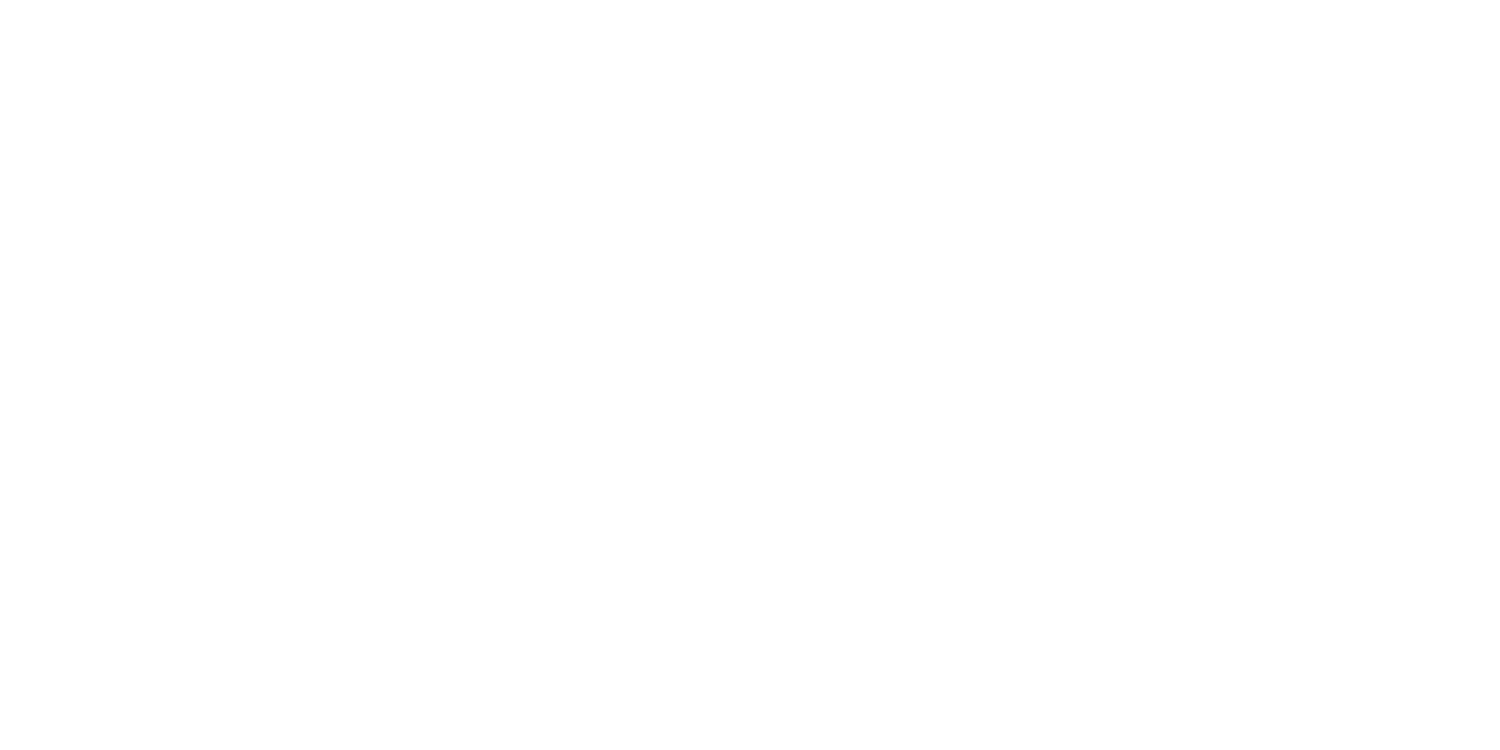

In [5]:
%matplotlib nbagg

scatter_size = 8
fig_fontsize = 10
dist_thresh = np.sqrt(cost_thresh * 2)
def draw_initial_plot():
    # Draw the plot
    fig = plt.figure(figsize=(5, 2.5), dpi=300)
    ax = fig.gca()
    ax.set_aspect('equal')
    plt.xlabel(r'$\mathrm{x}$', fontsize=fig_fontsize)
    plt.ylabel(r'$\mathrm{y}$', fontsize=fig_fontsize)
    ax.set_xlim(xlim_tup)
    ax.set_xticks(np.round(np.arange(xlim_tup[0], xlim_tup[1]+1, 2)))
    ax.set_ylim(ylim_tup)
    plt.grid()

    # Plot the trajectories
    draw_theta = np.linspace(0, 2 * np.pi, 100)
    for r in range(1, 20):
        r_temp = 1 * r
        plt.plot(target_position[0] + r_temp * np.cos(draw_theta),
                 target_position[1] + r_temp * np.sin(draw_theta),
                 color='k', linewidth=1)
    plt.scatter(initial_state[0], initial_state[1], scatter_size, marker='o',
                color='y', label=r'$\mathrm{Initial\ state}$', zorder=100)
    # plt.scatter(target_position[0], target_position[1], scatter_size,
    # marker = '*', color='r', zorder=11, label=r'$\mathrm{Target\ state}$')
    plt.plot(target_position[0] + dist_thresh * np.cos(draw_theta),
             target_position[1] + dist_thresh * np.sin(draw_theta),
             color='k', linestyle=':', linewidth=1,
             label=r'$\mathrm{Target\ set}$', zorder=9)
    # label=r'$\mathrm{Relaxed\ target\ state}$', zorder=9)
    plt.scatter(rand_init_traj_vec[1:, 0], rand_init_traj_vec[1:, 1], scatter_size,
                marker='s', color='b', label=r'$\mathrm{Initial\ data}$', zorder=13)
    plt.plot(rand_init_traj_vec_hiRes[1:-1, 0], rand_init_traj_vec_hiRes[1:-1, 1], color='b')
    plt.tight_layout()
    ax.legend()
    return ax

ax = draw_initial_plot()
plt.show()

# Cost function and the first-order oracle

We define the cost as half of the squared distance of the next state to a target position. We use the following context for this problem --- position in $\mathrm{xy}$ coordinates and express the heading $\theta\in\mathcal{S}^1$ by embedding it in $[-1,1]^2$, specifically $\sin(\theta),\cos(\theta)$. Therefore, the context $z$ corresponding to a state $x=[p_x,p_y,\theta]$ is $[p_x,p_y,\sin(\theta),\cos(\theta)]\in \mathbb{R}^2\times[-1,1]^2$.

We also require a first-order oracle that evaluates the cost given a context $z$ and input $u=[v,w]$ and computes the gradient with respect to $(z,u)$.

In [6]:
def compute_cost(next_state_mat):
    """
    next_state_mat is a Nx4 dimensional vector

    Returns a numpy 1D matrix
    :param next_state_mat:
    :return:
    """
    if next_state_mat.ndim != 2:
        raise ValueError('next_state_mat must be a 2D numpy matrix')
    delta_x_y = next_state_mat[:, :2] - np.tile(target_position[:2],
                                                (next_state_mat.shape[0], 1))
    cost = 0.5 * (np.linalg.norm(delta_x_y, axis=1)) ** 2
    return cost


def exit_condition(current_state, current_input, next_state):
    """
    Exit condition
    """
    return compute_cost(next_state) <= cost_thresh


def state_to_context(state):
    """
    Mapping from state to context
    """
    x, y, theta = state.T
    context_mat = np.vstack((x, y, np.sin(theta), np.cos(theta))).T
    return context_mat

def first_order_oracle(z_data):
    """
    Takes in context+input combination and provides cost function value and its gradient with respect to context+input
    """
    if z_data.shape[1] != 6:
        print(z_data.shape)
        raise ValueError('Requires feature and input vector (6 col matrix)')

    cost_vec = []
    grad_cost_vec = []
    for z in z_data:
        x, y, sh, ch, v, w = z[:]
        if abs(sh ** 2 + ch ** 2 - 1) > 1e-8:
            print('Error in the user-provided value: sin', sh, '| cos', ch)
            raise ValueError('Expected sin(heading)^2 + cos(heading)^2 == 1')
        if abs(w * sampling_time) >= 1e-5:
            nearly_one = np.sin(w * sampling_time)/(w * sampling_time)
            nearly_zero = (np.cos(w * sampling_time) - 1)/(w * sampling_time)
            # https://www.wolframalpha.com/input/?i=simplify+d%2Fdw+sin%28wt%29%2F%28wt%29
            # (t w cos(t w) - sin(t w))/(t w^2)
            nearly_one_dw = (sampling_time * w * np.cos(sampling_time * w)
                             - np.sin(sampling_time * w)) \
                                                    /(sampling_time * (w ** 2))
            # https://www.wolframalpha.com/input/?i=simplify+d%2Fdw+%28cos%28wt%29+-+1%29%2F%28wt%29
            # -(t w sin(t w) + cos(t w) - 1)/(t w^2)
            nearly_zero_dw = - (sampling_time * w * np.sin( sampling_time * w)
                                + np.cos(sampling_time * w) - 1) \
                                                    /(sampling_time * (w ** 2))
        else:
            nearly_zero = 0
            nearly_one = 1
            # They are constants
            nearly_zero_dw = 0
            nearly_one_dw = 0

        # Change in position
        delta_x = v * sampling_time * (ch * nearly_one + sh * nearly_zero)
        delta_y = v * sampling_time * (sh * nearly_one - ch * nearly_zero)

        # Cost definition
        current_state = np.array([[x, y, np.arctan2(sh, ch)]])
        current_input = np.array([[v, w]])
        next_state = one_step_dyn(current_state, current_input)
        cost_vec = np.hstack((cost_vec, compute_cost(next_state)))

        # Components of the gradient via chain rule
        cost_dx = 2 * (x + delta_x - target_position[0])
        cost_dy = 2 * (y + delta_y - target_position[1])
        cost_dsh = cost_dx * (v * sampling_time * nearly_zero) +\
                   cost_dy * (v * sampling_time * nearly_one)
        cost_dch = cost_dx * (v * sampling_time * nearly_one) -\
                   cost_dy * (v * sampling_time * nearly_zero)
        cost_dv = cost_dx * sampling_time * (ch * nearly_one + sh* nearly_zero)\
                + cost_dy * sampling_time * (sh * nearly_one - ch* nearly_zero)
        cost_dw = cost_dx*v*sampling_time*(ch*nearly_one_dw+sh*nearly_zero_dw)\
                + cost_dy*v*sampling_time*(sh*nearly_one_dw-ch*nearly_zero_dw)
        grad_cost = [cost_dx, cost_dy, cost_dsh, cost_dch, cost_dv, cost_dw]
        grad_cost_vec.append(grad_cost)

    return cost_vec, np.array(grad_cost_vec)/2

# Using `congol` for C2Opt

<IPython.core.display.Javascript object>


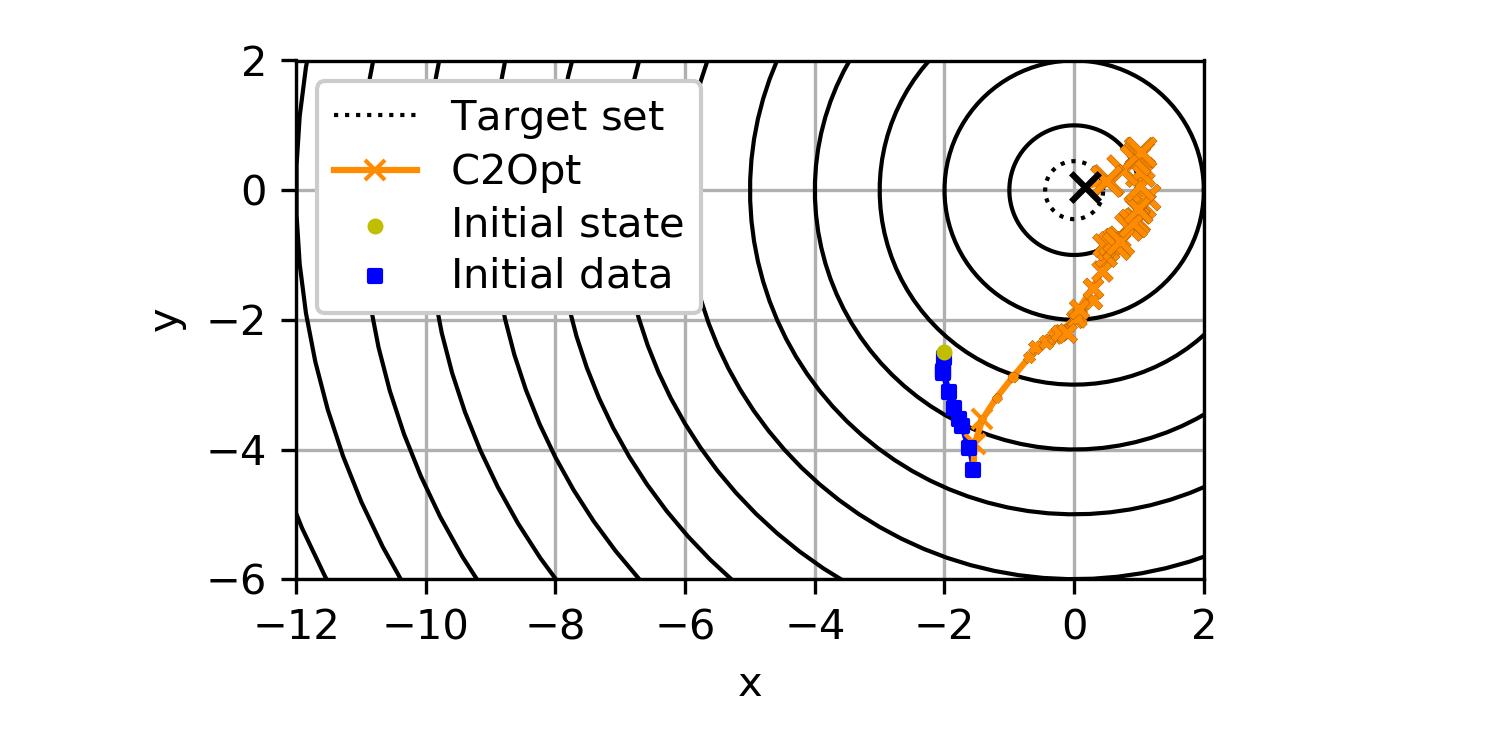


0. Current Context: [[-1.56 -4.31  1.   -0.04]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-1.56 -4.31  1.   -0.04  4.   -1.89]] | Optimistic cost = 7.8121 | Time = 0.1017 s 

1. Current Context: [[-1.53 -3.91  0.99  0.15]]
Solution strategy: midgap-lp-cvxpy


/workspace/Software/anaconda3/envs/congolexamples/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


z_query = [[-1.53 -3.91  0.99  0.15  4.   -3.14]] | Optimistic cost = 7.1391 | Time = 0.0991 s 

2. Current Context: [[-1.41 -3.53  0.89  0.45]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-1.41 -3.53  0.89  0.45  4.   -2.25]] | Optimistic cost = 5.5041 | Time = 0.0950 s 

3. Current Context: [[-1.2  -3.2   0.77  0.63]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-1.2  -3.2   0.77  0.63  4.    0.42]] | Optimistic cost = 4.0340 | Time = 0.0599 s 

4. Current Context: [[-0.95 -2.88  0.8   0.6 ]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-0.95 -2.88  0.8   0.6   4.   -1.02]] | Optimistic cost = 3.2540 | Time = 0.0757 s 

5. Current Context: [[-0.69 -2.58  0.73  0.68]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-0.69 -2.58  0.73  0.68  4.   -2.23]] | Optimistic cost = 2.0479 | Time = 0.1275 s 

6. Current Context: [[-0.39 -2.32  0.56  0.83]]
Solution strategy: midgap-lp-cvxpy
z_query = [[-0.39 -2.32  0.56  0.83 -2.39 -3.14]] | Optimistic cost = 0.8185 | Time = 0.0814 s 

7. 

z_query = [[ 0.5   0.14  0.3   0.95 -3.41 -0.98]] | Optimistic cost = -0.5188 | Time = 0.3726 s 


In [7]:
%matplotlib nbagg

grad_lips_constant = 1e1                     # Lipschitz constant for the gradient
solver_style = 'midgap-lp-cvxpy'             # Solution strategies: 'midgap-lp', 'cm-ncvx', 'midgap-lp-cvxpy'
                                             # First two requires Gurobi. midgap-lp is C2Opt while cm-ncvx comes 
                                             # with sublinear regret guarantees

# Compute the context vector        
rand_init_context_input_vec = np.hstack((state_to_context(rand_init_traj_vec[:-1, :]), rand_init_input_vec))
rand_init_cost_val_vec, rand_init_cost_grad_vec = first_order_oracle(rand_init_context_input_vec) 
training_data = {'trajectory': rand_init_traj_vec,
                 'input_seq': rand_init_input_vec,
                 'cost_val': rand_init_cost_val_vec,
                 'cost_grad': rand_init_cost_grad_vec}

# Provide `congol` all the information available about the problem
smddc_obj = cg.SmoothMyopicDataDrivenControl(training_data,
                                             state_to_context, 
                                             context_u_lb, 
                                             context_u_ub, 
                                             first_order_oracle, 
                                             grad_lips_constant, 
                                             one_step_dyn,
                                             exit_condition)

# Compute the solution for max_oracle_calls (time steps) or till exit_condition is true, whichever is earliest
ax = draw_initial_plot()
res = smddc_obj.solve(solver_style, max_oracle_calls, ax=ax, draw_plots_at_the_end=False)

# Compute the trajectory vector
context_vec = smddc_obj.contextual_optimizer.objective.arg[:,:smddc_obj.context_arg_dim]
congol_input_vec = smddc_obj.contextual_optimizer.objective.arg[:,smddc_obj.context_arg_dim:]
congol_x, congol_y, congol_sh, congol_ch = context_vec.T
congol_traj_vec = np.vstack((congol_x, congol_y, np.arctan2(congol_sh, congol_ch))).T
congol_cost_vec = smddc_obj.contextual_optimizer.objective.fun
ax.legend(loc='upper left', ncol=1, prop={'size': 1 * fig_fontsize}, labelspacing=0.25, framealpha=1)
plt.tight_layout()
plt.show()